<a href="https://colab.research.google.com/github/akshaypat444/pytorch_experiments/blob/main/make_more_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-30 03:53:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-07-30 03:53:23 (8.72 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
words = [word.lower() for word in words]

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

num_parameters = sum(p.nelement() for p in parameters)
print(num_parameters)
for p in parameters:
  p.requires_grad = True

12297


In [8]:
lossi = []
steps = []

In [9]:
max_steps = 50000
batch_size = 32

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward Pass
  emb = C[Xtr[ix]]
  embcat =emb.view(emb.shape[0], -1)
  hpre_act = embcat @ W1 + b1
  hpre_act = bngain * (hpre_act - hpre_act.mean(0, keepdims=True)) / hpre_act.std(0, keepdims=True) + bnbias
  h = torch.tanh(hpre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/  50000: 3.3147
  10000/  50000: 2.1984
  20000/  50000: 2.3375
  30000/  50000: 2.4359
  40000/  50000: 2.0119


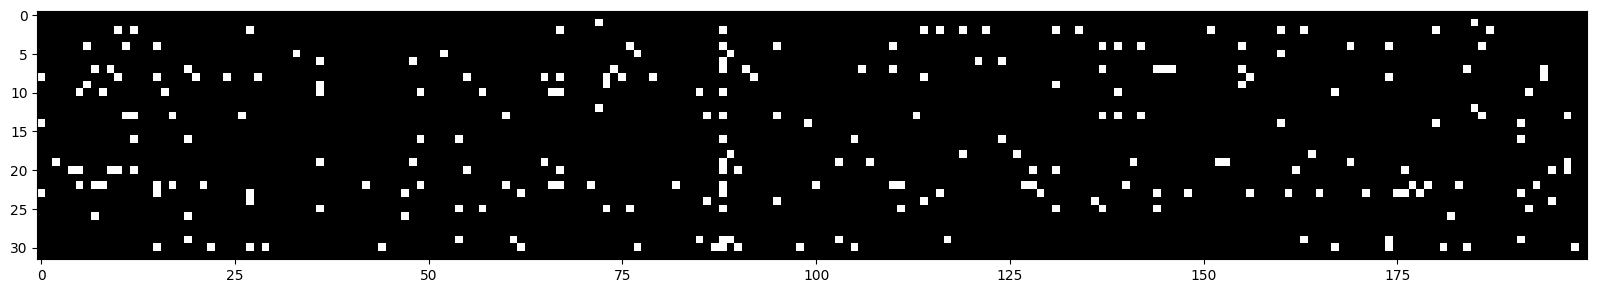

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

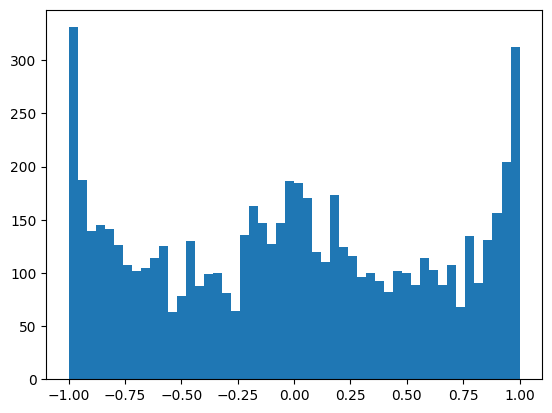

In [11]:
plt.hist(h.view(-1).tolist(), 50);

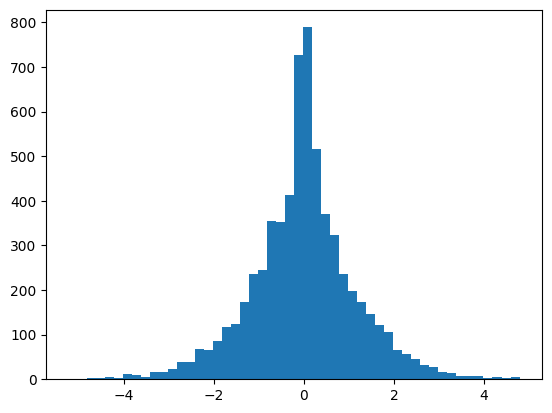

In [12]:
plt.hist(hpre_act.view(-1).tolist(), 50);

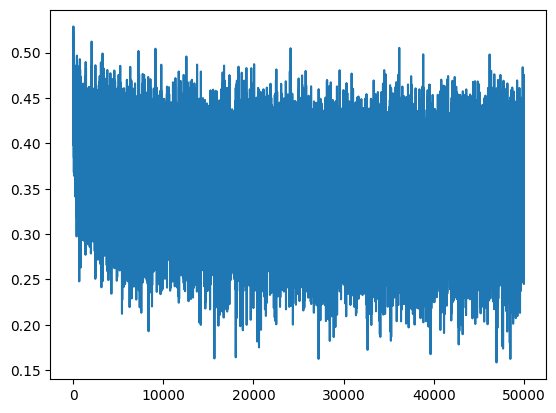

In [13]:
plt.plot(lossi)

In [14]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpre_act = embcat @ W1 + b1
  hpre_act = bngain * (hpre_act - hpre_act.mean(0, keepdims=True)) / hpre_act.std(0, keepdims=True) + bnbias
  h = torch.tanh(hpre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.161442518234253
val 2.190019369125366


In [15]:
# Sample from NN model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]

    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

junndelianasiz.
dillargeliza.
dibrithlianshtel.
bdannikaydangellassdbduinmwistavsnayannylantellaviumthya.
dtumj.
prynsleah.
janqucfredya.
briffrenabdin.
dimbigmwyn.
dragrasnamviktonszahddgossmfndigh.
